# Rapport
- Balthazar Neveu
- balthazarneveu@gmail.com
- [Lab 2 on github](https://github.com/balthazarneveu/MVA23_SIGNAL/tree/lab_2)

In [390]:
import numpy as np
import sklearn as skl
import json
import pandas as pd
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pathlib import Path
from typing import List, Dict, Tuple, Any, Union
import scipy

Commençons par une première passe d'homogénéisation du jeu de donnée. En effet, l'échantillonnage temporal n'est pas régulier... l'horodatage n'est pas le même pour tous les signaux.
Afin de simplifier la visualisation et le travail sur les données, nous allons simplement ré-échantillonner le tout (timestamps réguliers, échantillonnage à 10HZ).
Chaque signal aura 100 échantillons ce qui permet d'avoir un volume raisonnable et même de supperposer les différents signaux pour les comparer.

In [340]:
# DATA "UNIFORMIZATION" -> sample all signals on a regular timeline 
# Regular timeline = 10 seconds with 100 elements (we may get a bit of aliasing)
# Then we may navigate this data as a regular data structure (could fit in an excel).
# timestamps are now exactly the same for all signals.


# - la date de début de détection de l'impulsion (en ms)
# - la largeur ou durée de l'impulsion (en ms)
# - la puissance de l'impulsion (en dB / référence) 
# - l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
# - la fréquence de l'impulsion (en Ghz)

def homogenize_dataset(dataset="train", data_path = Path("radars")) -> pd.DataFrame:
    """This function is used to normalize and standardize a dataset.
    It converts non-uniformly sampled signals into a regular timeline
    and normalizes the values to standard units.
    The resulting DataFrame is easier to work with for further data analysis or machine learning tasks.
    Note: we may loose information due to resampling / get some aliasing.

    Parameters:
    dataset (str): The dataset to be homogenized. Default is "train".
    data_path (Path): The path to the directory containing the dataset. Default is "radars".

    Returns:
    DataFrame: A pandas DataFrame containing the homogenized dataset.
    """
    data = []
    values_units = [
        ("largeur", 1.E-3),
        ("frequence",1.E9),
        ("puissance" ,1.),("theta", 1.),
        ("phi", 1.)
    ]
    with open(data_path/f'{dataset}_labels.json') as f:
        dict_labels_current = json.load(f)
    for idx in range(799):
        pdws = np.load(data_path/ dataset / f'pdw-{idx}.npz')
        target = dict_labels_current[f'pdw-{idx}']=="nonmenace"
        dates = pdws['date']
        uniform_timestamps = np.linspace(0, 10.E3, 100)
        new_dic = {}
        for label, scale in values_units: #normalize to standard units (Hz, seconds)
            non_uniform_value = pdws[label]
            regular_sampling = np.interp(uniform_timestamps, xp=dates, fp=non_uniform_value)
            new_dic[label] = regular_sampling*scale
        new_dic["menace"] = not target
        diff_ts  =(dates[1:]-dates[:-1])/1000.
        new_dic["timestamps_interval_multiples"] = np.round(diff_ts/np.min(diff_ts))
        new_dic["impulsion_freq"] = 1./np.min(diff_ts)
        data.append(new_dic)
    df = pd.DataFrame.from_dict(data)
    return df

In [341]:
df = df_train = homogenize_dataset(dataset="train")
df_test = homogenize_dataset(dataset="test")
df.head()

,largeur,frequence,puissance,theta,phi,menace,timestamps_interval_multiples,impulsion_freq
0,"[0.00029099999999999997, 0.0002911010187641941...","[2222011346.301772, 2201167919.9721026, 221708...","[-125.58248735699023, -115.0846158693843, -108...","[0.9578859532471261, 0.8703978859546783, 0.607...","[1.678935775441994, 1.7243409379102963, 1.6140...",False,"[16.0, 8.0, 20.0, 26.0, 12.0, 1.0, 26.0, 4.0, ...",677.048070
1,"[0.00013800000000000002, 0.0001369258365512231...","[3011221070.570557, 2996006530.9250755, 300603...","[-127.176799666022, -157.8781625154061, -137.9...","[2.7962717807754327, -2.829550985701179, -2.48...","[1.5296932038533972, 1.5546468454693552, 1.632...",False,"[17.0, 6.0, 7.0, 10.0, 2.0, 35.0, 25.0, 55.0, ...",1092.896175
2,"[0.000201, 0.0002018786859303869, 0.000201, 0....","[991990464.3038368, 982743904.1435359, 9898809...","[-149.880060930416, -151.7229884218102, -153.5...","[-2.0412578355641227, -1.9204468635231988, -1....","[1.6722396416013094, 1.7759924411327765, 1.509...",True,"[15.0, 5.0, 3.0, 1.0, 2.0, 41.0, 1.0, 20.0, 13...",634.517766
3,"[6.800000000000001e-05, 6.928607233324905e-05,...","[1666424017.2021985, 1668061021.2198102, 16641...","[-135.68775777002037, -134.56670065032353, -13...","[-2.621701006244045, -2.2862588398101207, -2.1...","[1.4039557266900524, 1.6190396944122287, 1.690...",False,"[16.0, 3.0, 2.0, 2.0, 8.0, 15.0, 6.0, 23.0, 10...",1466.275660
4,"[0.000324, 0.0003248032831089071, 0.0003248041...","[2207809393.1871147, 2200771938.7002068, 22022...","[-172.60362010919195, -151.87364054688302, -15...","[2.274032092616462, 2.127649080211378, 2.36297...","[1.6134753329852611, 1.6012352706627135, 1.745...",False,"[17.0, 1.0, 4.0, 5.0, 25.0, 27.0, 1.0, 21.0, 2...",604.960678



## Phase exploratoire
On commence par chercher des critères simples (statistiques basiques des signaux)  pour classifier les données.

### Min puissance
- Si on fait défiler les signaux de puissance en figeant l'échelle verticale, nous remarquons clairement un "paquet" au dessus des autres.
- Un descripteur très simple pour discriminer la menace correspond au mimimum de la puissance. On sait déjà qu'il n'est pas suffisant (au vu du gros "paquet" vert et rouge)

![](figures/superposition_signaux_puissance.png)


### Moyenne et puissance des fréquences

- L'étude de l'évolution temporelle des fréquences ne révèle pas de fluctuations perceptibles (signaux stationnaires).

![](figures/superposition_signaux_frequence.png)

- On peut simplement évaluer les moments et ainsi tracer la distribution moyenne des fréquences ainsi que l'écart type



En poussant un peu l'étude manuelle des caractéristiques, on commence à arriver à distinguer quelques groupes:
- écart type(1/fréquence)/moyenne(1/fréquence)
- min(puissance)

![](figures/x=freq_avg_y=freq_std_div_freq_avg.png)


Un arbre de décision devrait permettre de classifier les données (partitionner l'espace en plusieurs rectangles).


## Classification basique
Une approche rationnelle consiste à aggréger les caractéristiques et entraîner un classifieur simple (arbre de décisions) en jouant sur sa profondeur.
Plus on ajoute de caractéristiques, plus on espère que la précision du modèle augmente


![decision_tree](figures/decision_tree.png)

- Avec une unique caractéristique (bien choisie) et un unique seuil, nous atteignons 70% de précision.
- En augmentant la profondeur de l'arbre de décision jusqu'à 4, nous atteignons une précision de 75%
- Avec 2 caractéristiques, nous remarquons qu'il est nécessaire d'avoir une profondeur de 4 sur l'arbre de décision afin d'atteindre la précision optimale.
- Nous remarquons qu'au delà d'une profondeur de 6, l'arbre de décision est à la limite de "sur-apprentissage" (la précision sur la base d'entraînement augmente alors que la précision de validation stagne ou commence à diminuer.)

In [342]:
# "HANDCRAFTED" FEATURE COMPUTATION
def get_hand_crafted_features(df: pd.DataFrame, feature_dimension=None) -> Tuple[List, List]:
    inv_freq_mean = np.array([(1./el).mean() for el in df["frequence"]])
    freq_feature = np.array([(1./el).std()/((1./el).mean()) for el in df["frequence"]])
    min_pow = np.array([el.min() for el in df["puissance"]])
    largeur_mean = np.array([el.mean() for el in df["largeur"]])
    freq_std = np.array([el.std() for el in df["frequence"]])
    std_pow = np.array([el[20:50].std() for el in df["puissance"]])
    x = np.stack([freq_std, min_pow, std_pow, freq_feature, inv_freq_mean, largeur_mean], axis=1)
    if feature_dimension is not None:
        x=x[:, :feature_dimension]
    y = [1. if el else 0. for el in df["menace"]]
    return x, y

In [397]:
DECISION_TREE = "Decision tree"
SVM = "SVM classifier"
RANDOM_FOREST = "Random forest"
ADABOOST = "Ada Boost"
def train_classifier(
        x_train, x_test, y_train, y_test,
        feature_dimension=3,
        debug=False, show=True, forced_depth=None,
        classifier=DECISION_TREE,
    ) -> Tuple[np.ndarray, int]:
    COLOR_LIST = "rgbckyp"
    if feature_dimension is None:
        x_train_shrink, x_test_shrink = x_train, x_test 
    else:
        x_train_shrink, x_test_shrink = x_train[:, :feature_dimension], x_test[:, :feature_dimension]
    accuracies = []
    
    classifiers = []
    if classifier == DECISION_TREE or classifier == RANDOM_FOREST:
        depth_list = list(range(1, 10))
        for depth in depth_list:
            if classifier == DECISION_TREE:
                dt = DecisionTreeClassifier(max_depth=depth)
            else:
                dt = RandomForestClassifier(max_depth=depth, n_estimators=10, max_features=1, random_state=73)
            dt.fit(x_train_shrink, y_train)
            classifiers.append(dt)
            y_train_pred = dt.predict(x_train_shrink)
            y_test_pred = dt.predict(x_test_shrink)
            acc_train, acc_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
            accuracies.append([acc_train, acc_test])
            # if debug:
            #     print(f"accuracy training {acc_train:.1f} | accuracy test {acc_test:.1f}")
    elif classifier in [SVM, ADABOOST]:
        depth_list = [1]
        best_depth = 0
        if classifier == SVM:
            clas = SVC() 
        elif classifier == ADABOOST:
            clas = AdaBoostClassifier(n_estimators=50)
        clas.fit(x_train_shrink, y_train)
        classifiers.append(clas)
        y_train_pred = clas.predict(x_train_shrink)
        y_test_pred = clas.predict(x_test_shrink)
        acc_train, acc_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
        accuracies.append([acc_train, acc_test])
    else:
        raise NotImplementedError(f"Classifier {classifier} not implemented")
    accuracies = np.array(accuracies)
    if debug:
        col=COLOR_LIST[(feature_dimension-1)%len(COLOR_LIST)]
        plt.plot(depth_list, accuracies[:, 0], "--"+col, alpha=0.7, label=f"accuracy train #{feature_dimension} features")
        plt.plot(depth_list, accuracies[:, 1], "-"+col, alpha=0.7, label=f"accuracy test #{feature_dimension} features")
        plt.legend()
        plt.xlabel("Depth of the decision tree")
        plt.ylabel("Classifier accuracy")
        if show:
            plt.grid()
            plt.show()
    
    best_depth = np.argmax(accuracies[:, 1]) if forced_depth is None else forced_depth
    return accuracies[best_depth, :], depth_list[best_depth], classifiers[best_depth]



#features=1 Tree depth=4 accuracy training 76.3% | accuracy test 75.7%
#features=2 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%
#features=3 Tree depth=8 accuracy training 83.2% | accuracy test 80.1%
#features=4 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%


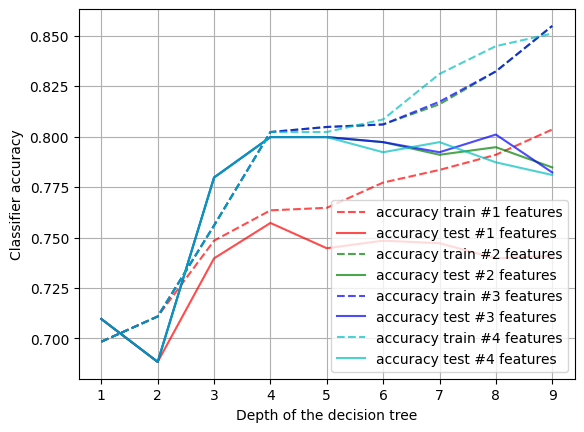

In [398]:
# Define the training and testing sets by extracting the features from the dataframes.
x_train, y_train = get_hand_crafted_features(df_train)
x_test, y_test = get_hand_crafted_features(df_test)

compare_plots = True
for feature_dimension in range(1, 5):
    accuracies, best_depth, _ = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=True,  show=not compare_plots)
    print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
if compare_plots:
    plt.grid()
    plt.show()

# Analyzing the time series

Let's first retieve some remaining "difficult" signals to classify.

In [399]:
features_to_keep = 2
accuracies, best_depth, classifier = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=features_to_keep, debug=False,  show=False, forced_depth=4)
y_train_pred = classifier.predict(x_train[:, :features_to_keep])
missclassified_indexes = np.where(y_train_pred!=y_train)[0]

In [400]:
all_indexes = df.index.values
# Get indexes that are not in missclassified_indexes
not_missclassified_indexes = np.setdiff1d(all_indexes, missclassified_indexes)

# Generate
num_indexes_to_choose = 100  # specify the number of indexes you want
random_indexes = np.random.choice(not_missclassified_indexes, num_indexes_to_choose, replace=False)
df_random = df.take(random_indexes).copy().reset_index()

In [401]:
df_hard = df.take(missclassified_indexes).copy()
df_hard.reset_index(inplace=True)

In [402]:
df_hard.menace.sum()/len(df_hard)

1.0

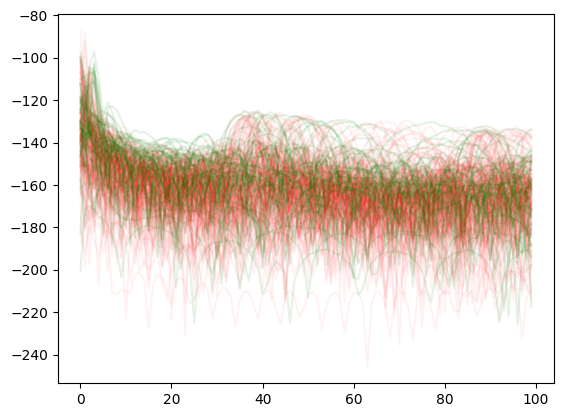

In [403]:
plt.plot(np.array([df_hard.puissance[idx] for idx in range(len(df_hard)) if df_hard.menace[idx]]).T, "r", alpha=0.05, label="menace")
plt.plot(np.array([df_hard.puissance[idx] for idx in range(len(df_hard)) if not df_hard.menace[idx]]).T, "g", alpha=0.05, label="safe")
plt.plot(np.array([df_random.puissance[idx] for idx in range(len(df_random)) if not df_random.menace[idx]]).T, "g", alpha=0.1, label="safe")
plt.show()

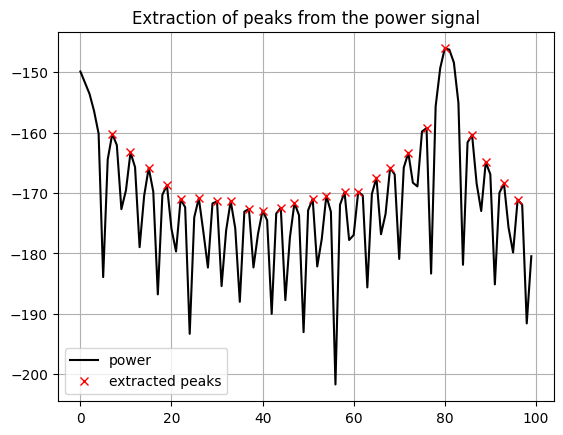

In [404]:
peaks, props =  scipy.signal.find_peaks(df_hard.puissance[0])
plt.plot(df_hard.puissance[0], "k-", label="power")
plt.plot(peaks, df_hard.puissance[0][peaks], "xr", label="extracted peaks")
plt.grid()
plt.title("Extraction of peaks from the power signal")
plt.legend()
plt.show()
# np.average(peaks[1:] - peaks[:-1])

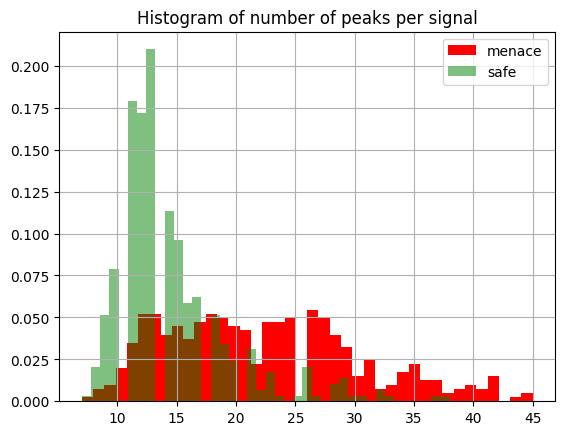

In [405]:
def extract_peaks(df, add_to_df=False):
    peaks_locations_list = []
    peaks_values_list = []
    for idx in range(len(df)):
        # if df_hard.menace[idx]:
        peaks = scipy.signal.find_peaks(df.puissance[idx])[0]
        peaks_locations_list.append(peaks)
        peaks_values_list.append(df.puissance[idx][peaks])
    if add_to_df:
        df["peaks_loc"] = peaks_locations_list
        df["peaks_val"] = peaks_values_list
    return peaks_locations_list, peaks_values_list

peaks, peak_vals = extract_peaks(df, add_to_df=True)
plt.hist([len(el) for idx, el in enumerate(df.peaks_loc) if df.menace[idx]], color="r", bins=40, label="menace", density=True)
plt.hist([len(el) for idx, el in enumerate(df.peaks_loc) if not df.menace[idx]], color="g", bins=40, alpha=0.5, label="safe", density=True)
plt.title("Histogram of number of peaks per signal")
plt.grid()
plt.legend()
plt.show()

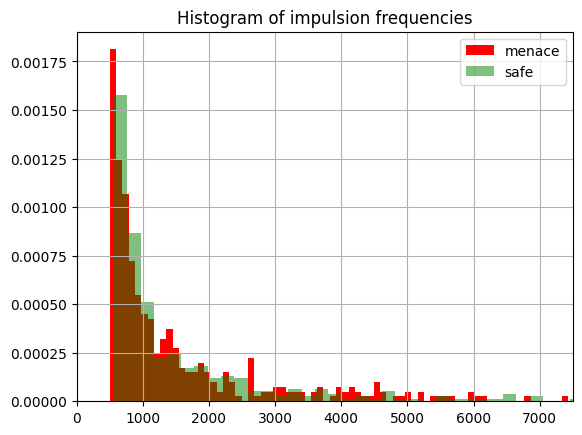

In [406]:
plt.hist([el for idx, el in enumerate(df.impulsion_freq) if df.menace[idx]], color="r", bins=100, label="menace", density=True)
plt.hist([el for idx, el in enumerate(df.impulsion_freq) if not df.menace[idx]], color="g", bins=100, alpha=0.5, label="safe", density=True)
plt.title("Histogram of impulsion frequencies")
plt.grid()
plt.xlim(0, 7500)
plt.legend()
plt.show()

#features=1 Tree depth=4 accuracy training 76.3% | accuracy test 75.7%
#features=2 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%
#features=3 Tree depth=5 accuracy training 87.7% | accuracy test 84.9%
#features=4 Tree depth=6 accuracy training 88.7% | accuracy test 85.0%
#features=5 Tree depth=6 accuracy training 88.6% | accuracy test 85.7%
#features=6 Tree depth=5 accuracy training 88.5% | accuracy test 84.7%


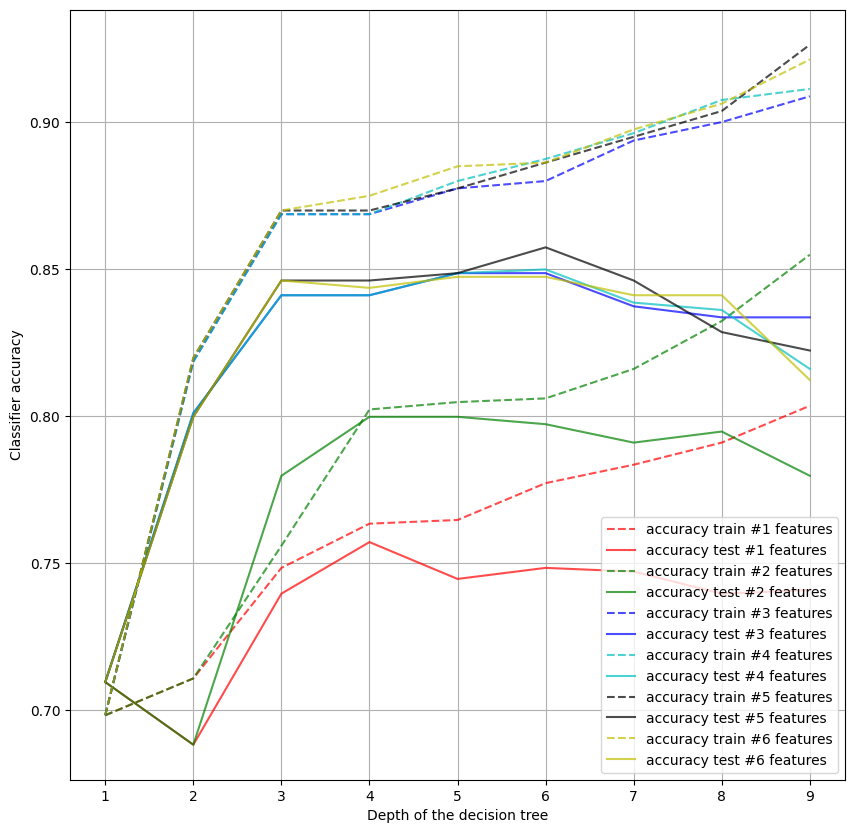

In [441]:
# "HANDCRAFTED" FEATURE COMPUTATION
def get_good_features(df: pd.DataFrame, feature_dimension=None) -> Tuple[List, List]:
    freq_std = np.array([el.std() for el in df["frequence"]])
    min_pow = np.array([el.min() for el in df["puissance"]])
    peak_len = np.array([len(el) for el in df["peaks_loc"]])
    peak_width = np.array([np.mean(el[1:] - el[:-1]) for el in df["peaks_loc"]])
    peak_vals_std = np.array([np.std(el) for el in df["peaks_val"]])
    peak_vals_mean = np.array([np.mean(el) for el in df["peaks_val"]])
    # ts_multiples = np.array([np.quantile(el, 0.9) for el in df["timestamps_interval_multiples"]])
    impulse_freq  = df.impulsion_freq
    x = np.stack([freq_std, min_pow, peak_len, 1./impulse_freq, peak_width, peak_vals_std, peak_vals_mean], axis=1)
    if feature_dimension is not None:
        x=x[:, :feature_dimension]
    y = [1. if el else 0. for el in df["menace"]]
    return x, y

# Define the training and testing sets by extracting the features from the dataframes.
extract_peaks(df_train, add_to_df=True)
extract_peaks(df_test, add_to_df=True)
x_train, y_train = get_good_features(df_train)
x_test, y_test = get_good_features(df_test)

plt.figure(figsize=(10, 10))
compare_plots = True
for feature_dimension in [1, 2] + list(range(3, 7)):
    accuracies, best_depth, _ = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=True,  show=not compare_plots)
    print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
if compare_plots:
    plt.grid()
    plt.show()

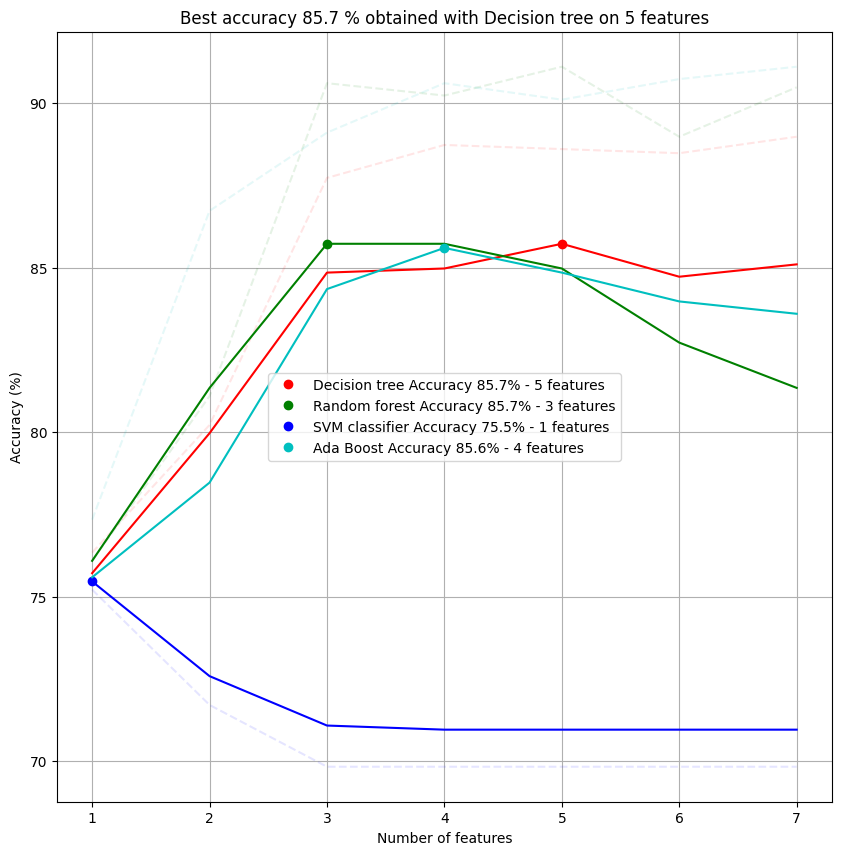

In [443]:
COLOR_LIST = "rgbckyp"
best_accuracies_overall = []
best_feature_dimensions = []
classifiers_list = [DECISION_TREE, RANDOM_FOREST, SVM, ADABOOST]
plt.figure(figsize=(10, 10))
for classifier_index, classifier_type in enumerate(classifiers_list):
    best_accuracies = []
    feature_dimensions = []
    color = COLOR_LIST[classifier_index%len(COLOR_LIST)]
    for feature_dimension in range(1, 8):
        accuracies, best_depth, _ = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=False,  show=False, classifier=classifier_type)
        # print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
        best_accuracies.append(accuracies)
        feature_dimensions.append(feature_dimension)
    plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 0], color+"--", alpha=0.1) #label=f"{classifier_type} accuracy train")
    plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 1], color+"-") #label=f"{classifier_type} accuracy validation")
    best_index = np.argmax(np.array(best_accuracies)[:, 1])
    best_accuracy = best_accuracies[best_index][1]
    best_feature_dimension = feature_dimensions[best_index]
    plt.plot(feature_dimensions[best_index], 100.*best_accuracy, color+"o", label=f"{classifier_type} Accuracy {100*best_accuracy:.1f}% - {best_feature_dimension} features")
    plt.legend()
    best_accuracies_overall.append(best_accuracy)
    best_feature_dimensions.append(best_feature_dimension)
best_classifier_index = np.argmax(np.array(best_accuracies_overall))
plt.title(f"Best accuracy {100*best_accuracies_overall[best_classifier_index]:.1f} % obtained with {classifiers_list[best_classifier_index]} on {best_feature_dimensions[best_classifier_index]} features")
plt.xlabel("Number of features")
plt.ylabel(r"Accuracy (%)")
plt.grid()
plt.show()


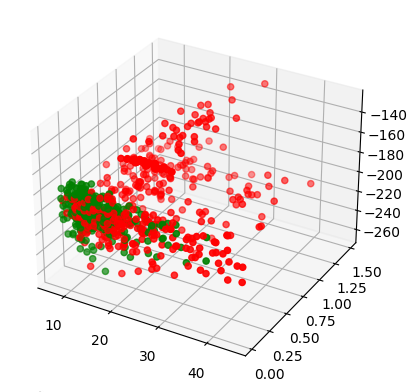

In [440]:
colors = ["r" if el else "g" for el in df["menace"]]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train[:, 2], x_train[:, 0], x_train[:, 1], color=colors)
plt.show()
